# Holy search for Determinism

In [97]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 7

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
#tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# 6. Keras
tf.keras.utils.set_random_seed(seed_value)
tf.config.experimental.enable_op_determinism()

In [48]:
import tensorflow as tf
from tensorflow import keras

'''

# Determinism
tf.keras.utils.set_random_seed(7)
tf.config.experimental.enable_op_determinism()

from numpy.random import seed
seed(7)
tf.random.set_seed(7)
'''

'\n\n# Determinism\ntf.keras.utils.set_random_seed(7)\ntf.config.experimental.enable_op_determinism()\n\nfrom numpy.random import seed\nseed(7)\ntf.random.set_seed(7)\n'

# Tests GPU local

In [49]:
print("GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs: 0


In [50]:
tf.test.is_built_with_cuda()

True

In [51]:
print(tf.version.VERSION)

2.8.0


In [52]:
import sys
sys.version

'3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]'

In [53]:
'''
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
'''

'\nfrom tensorflow.python.client import device_lib\n\ndef get_available_devices():\n    local_device_protos = device_lib.list_local_devices()\n    return [x.name for x in local_device_protos]\n\nprint(get_available_devices())\n'

# TP

In [54]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path
import math

# lib para trabajar con arrays
import numpy as np
import pandas as pd
import sklearn

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
import seaborn as sns

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [55]:
from tensorflow.keras.datasets import fashion_mnist
'''
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
(X_train, Y_train) = train 
(X_test, Y_test) = test
'''
train, test = fashion_mnist.load_data()
(X_train, Y_train) = train 
(X_test, Y_test) = test

In [56]:
# CONSTANTES

LABELS = np.unique(Y_train).tolist()
LABELS_TEXT = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
INPUTS = 28*28
OUTPUTS = len(LABELS)

# EDA

El dataset se divide en un set de train con 60.000 ejemplos, y un set de test con otros 10.000. Cada ejemplo consta de una imagen en escala de grises de 28x28 pixeles (784 en total), asociado a una etiqueta de 10 clases.
Cada pixel es representado por un solo valor, indicando el nivel de brillo u obscuridad en él. Estos valores van entre 0 y 255.

### Etiquetas
- 0 - T-shirt/top
- 1 - Trouser
- 2 - Pullover
- 3 - Dress
- 4 - Coat
- 5 - Sandal
- 6 - Shirt
- 7 - Sneaker
- 8 - Bag
- 9 - Ankle boot

Las dimensiones de las imágenes pueden apreciarse al hacer un `.shape` de los datasets:

In [57]:
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (60000, 28, 28)
Test: (10000, 28, 28)


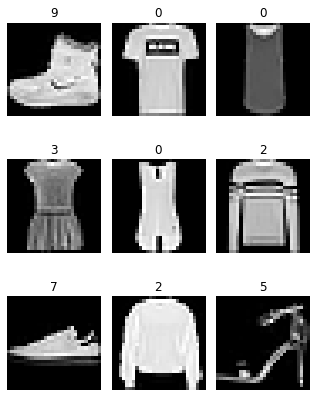

In [14]:
def sample_images(dataset): 
    # specify the number of rows and columns you want to see
    num_row = 3
    num_col = 3

    # get a segment of the dataset
    num = num_row*num_col
    if dataset == train:
        images, labels = X_train[:num], Y_train[:num]
    else: # Test dataset
        images, labels = X_test[:num], Y_test[:num]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

sample_images(train)

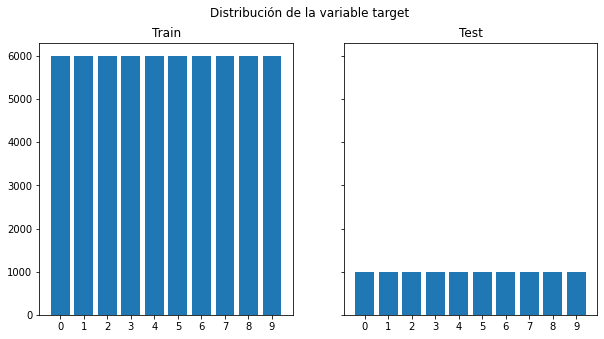

In [15]:
df_ytrain = pd.DataFrame(data=Y_train)
df_ytest = pd.DataFrame(data=Y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
fig.suptitle('Distribución de la variable target')
ax1.bar([0,1,2,3,4,5,6,7,8,9],df_ytrain.value_counts())
ax2.bar([0,1,2,3,4,5,6,7,8,9],df_ytest.value_counts())
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax1.title.set_text('Train')
ax2.title.set_text('Test')

La variable a predecir tiene una **distribución uniforme** en todo ambos datasets.

In [16]:
# Escalado de valores a un rango 0-1

#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

# Data Augmentation

Activation functions
    https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

Loss functions
    https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

Neurons and layers
    https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

https://www.hindawi.com/journals/mpe/2013/425740/
https://peerj.com/articles/cs-724/

    The number of hidden neurons should be between the size of the input layer and the size of the output layer.
    The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
    The number of hidden neurons should be less than twice the size of the input layer.


> In modern neural networks, the default recommendation is to use the rectified linear unit or ReLU …

— Page 174, Deep Learning, 2016.

# Funciones

In [98]:
EPOCHS = 50
BATCH_SIZE = 256
VERBOSE = 0

import matplotlib.ticker as ticker

# Fit model
def fit_model(model, epochs=EPOCHS, batch_size=BATCH_SIZE, plot_model=True, verbose=VERBOSE, compare=False):
    history = model.fit(
        X_train,
        Y_train,
        epochs = epochs,
        batch_size = batch_size,
        validation_data=(X_test, Y_test),
        verbose=verbose,
    )

    if verbose == 0:
        print('Trained the model for', epochs, 'epochs')

        final_train_accuracy = model.history.history['accuracy'][-1]
        final_validation_accuracy = model.history.history['val_accuracy'][-1]
        final_train_loss = model.history.history['loss'][-1]
        final_validation_loss = model.history.history['val_loss'][-1]

        if compare:
            initial_train_accuracy = model.history.history['accuracy'][0]
            initial_validation_accuracy = model.history.history['val_accuracy'][0]
            initial_train_loss = model.history.history['loss'][0]
            initial_validation_loss = model.history.history['val_loss'][0]

            print('- Train: \t Initial Accuracy:', format(round(initial_train_accuracy, 4), '.4f'), 
                '\t Final Accuracy:', format(round(final_train_accuracy, 4), '.4f'), 
                '\t Initial Loss:', format(round(initial_train_loss, 4), '.4f'), 
                '\t Final Loss:', format(round(final_train_loss, 4), '.4f'))
            print('- Validation: \t Initial Accuracy:', format(round(initial_validation_accuracy, 4), '.4f'), 
                '\t Final Accuracy:', format(round(final_validation_accuracy, 4), '.4f'), 
                '\t Initial Loss:', format(round(initial_validation_loss, 4), '.4f'), 
                '\t Final Loss:', format(round(final_validation_loss, 4), '.4f'))    
        else:
            print('- Train: \t Accuracy:', format(round(final_train_accuracy, 4), '.4f'), '\t Loss:', format(round(final_train_loss, 4), '.4f'))
            print('- Validation: \t Accuracy:', format(round(final_validation_accuracy, 4), '.4f'), '\t Loss:', format(round(final_validation_loss, 4), '.4f'))

    return history

# Plot train and validation accuracy of up to three models
def plot_model(model_1, model_2=None, model_3=None, loss=False, title='', subtitle_1='', subtitle_2='', subtitle_3='', epochs=EPOCHS):
    if loss:
        ylabel = 'Loss'
        train_metric = 'loss'
        validation_metric = 'val_loss'
    else:
        ylabel = 'Accuracy'
        train_metric = 'accuracy'
        validation_metric = 'val_accuracy'

    if model_2 is None and model_3 is None:
        plt.figure(figsize=(7, 5)) 
        plt.title(title)
        plt.plot(model_1.history[train_metric], label='train')
        plt.plot(model_1.history[validation_metric], label='validation')
        if epochs <= 20:
            plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
        else:
            original_ticks_list = np.arange(epochs)
            # Just 3 ticks (min, half, max)
            new_ticks_list = [min(original_ticks_list), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)]
            new_ticks_label_list = [min(original_ticks_list+1), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)+1]
            plt.xticks(new_ticks_list, new_ticks_label_list)
       
        plt.ylabel(ylabel)
        plt.xlabel('Epoch')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
        
    else:
        if model_3 is None:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15.3, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax1.plot(model_1.history[train_metric], label='train')
            ax2.plot(model_2.history[train_metric], label='train')
            ax1.plot(model_1.history[validation_metric], label='validation')
            ax2.plot(model_2.history[validation_metric], label='validation')

            axes_list = [ax1, ax2]

        else:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(24, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax3.title.set_text(subtitle_3)
            ax1.plot(model_1.history[train_metric], label='train')
            ax2.plot(model_2.history[train_metric], label='train')
            ax3.plot(model_3.history[train_metric], label='train')
            ax1.plot(model_1.history[validation_metric], label='validation')
            ax2.plot(model_2.history[validation_metric], label='validation')
            ax3.plot(model_3.history[validation_metric], label='validation')

            ax2.tick_params(
            axis='y',
            which='both',   
            left=False
            )  

            axes_list = [ax1, ax2, ax3]

        for ax in axes_list:
            if epochs <= 20:
                ax.set_xticks(np.arange(epochs), np.arange(1, epochs+1))
            else:
                original_ticks_list = np.arange(epochs)
                # Just 3 ticks (min, half, max)
                new_ticks_list = [min(original_ticks_list), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)]
                new_ticks_label_list = [min(original_ticks_list+1), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)+1]
                ax.set_xticks(new_ticks_list, new_ticks_label_list)
            
            ax.set_xlabel('Epoch')
            ax.set_ylabel(ylabel)
            ax.legend(loc='best')
            ax.grid()

            ax.tick_params(
                axis='y',
                which='both',   
                right=False,
                labelright=False,
                left=True,
                labelleft=True,
            )

# Plot train and validation accuracy of up to three models
def plot_cm(model_1, model_2=None, model_3=None, dataset=train, title='', subtitle_1='', subtitle_2='', subtitle_3=''):
    X_train, Y_train = dataset
    labels = Y_train #Rename just for the sake of understanding

    if model_2 is None and model_3 is None:
        predictions = np.argmax(model_1.predict(X_train), axis=-1)
        
        print(' - Accuracy:', accuracy_score(labels, predictions))

        fig, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(confusion_matrix(labels, predictions), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT)

        plt.title(title)
        plt.xlabel('Predicted class') 
        plt.ylabel('True class') 
        
    else:
        if model_3 is None:
            predictions_model_1 = np.argmax(model_1.predict(X_train), axis=-1)
            predictions_model_2 = np.argmax(model_2.predict(X_train), axis=-1)

            print(' -', subtitle_1,'Accuracy:', accuracy_score(labels, predictions_model_1))
            print(' -', subtitle_2,'Accuracy:', accuracy_score(labels, predictions_model_2))

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15.3,5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            axes_list = [ax1, ax2]
            g1 = sns.heatmap(confusion_matrix(labels, predictions_model_1), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax1)
            g2 = sns.heatmap(confusion_matrix(labels, predictions_model_2), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax2)

        else:
            predictions_model_1 = np.argmax(model_1.predict(X_train), axis=-1)
            predictions_model_2 = np.argmax(model_2.predict(X_train), axis=-1)
            predictions_model_3 = np.argmax(model_3.predict(X_train), axis=-1)

            print(' -', subtitle_1,'Accuracy:', accuracy_score(labels, predictions_model_1))
            print(' -', subtitle_2,'Accuracy:', accuracy_score(labels, predictions_model_2))
            print(' -', subtitle_3,'Accuracy:', accuracy_score(labels, predictions_model_3))

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax3.title.set_text(subtitle_3)
            axes_list = [ax1, ax2, ax3]
            g1 = sns.heatmap(confusion_matrix(labels, predictions_model_1), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax1)
            g2 = sns.heatmap(confusion_matrix(labels, predictions_model_2), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax2)
            g3 = sns.heatmap(confusion_matrix(labels, predictions_model_3), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax3)

        for ax in axes_list:
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

    plt.tight_layout()
    plt.show()

# Tests académicos

## Masters (1993)

Masters argumenta en su libro *Practical Neural Network Recipes in C++* que no hay razones teóricas para utilizar más de dos capas ocultas en una red neuronal, como así tampoco razones prácticas. A su vez, propone utilizar la regla de la pirámide geométrica para determinar el número de neuronas ocultas, la cual establece que el número de neuronas para cada capa oculta formará una pirámide, donde el número de neuronas sigue disminuyendo de entrada a salida.

Para una red neuronal con una sola capa oculta, la cantidad de neuronas se calcula de la siguiente manera:

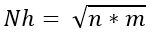

Donde:
- n es la cantidad de inputs
- m es la cantidad de outputs

Por otro lado, la cantidad de neuronas para una red con dos capas ocultas se calcula así:

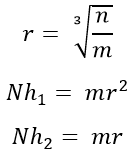

Si se quisiera utilizar este mismo principio para una red con tres capas ocultas, a cantidad de neuronas en cada una de ellas se calcula de esta manera:

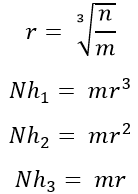

In [ ]:
Nh = pow(INPUTS*OUTPUTS, 1/2)

mlp_masters_1l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_1l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh))
print()

mlp_masters_1l.summary()

In [ ]:
mlp_masters_1l_fit = fit_model(mlp_masters_1l)

In [ ]:
#r = (n/m)^(1/3)
r = pow(INPUTS/OUTPUTS, 1/3)    # = 4.279
                                
Nh1 = OUTPUTS*pow(r,2)          # = 183.179
Nh2 = OUTPUTS*r                 # = 42.799
                            
mlp_masters_2l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh1, activation='sigmoid'),
    Dense(Nh2, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_2l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:')
print('    - 1st Layer:', math.trunc(Nh1))
print('    - 2nd Layer:', math.trunc(Nh2))
print()

mlp_masters_2l.summary()

In [ ]:
mlp_masters_2l_fit = fit_model(mlp_masters_2l)

In [ ]:
#r = (n/m)^(1/3)
r = pow(INPUTS/OUTPUTS, 1/3)    # = 4.279
                                
Nh1 = OUTPUTS*pow(r,3)          # = 783.478
Nh2 = OUTPUTS*pow(r,2)          # = 183.179
Nh3 = OUTPUTS*r                 # = 42.799
                            
mlp_masters_3l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh1, activation='sigmoid'),
    Dense(Nh2, activation='sigmoid'),
    Dense(Nh3, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_3l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:')
print('    - 1st Layer:', math.trunc(Nh1))
print('    - 2nd Layer:', math.trunc(Nh2))
print('    - 3rd Layer:', math.trunc(Nh3))
print()

mlp_masters_3l.summary()

In [ ]:
mlp_masters_3l_fit = fit_model(mlp_masters_3l)

In [ ]:
# Comparison between all three models based on Masters idea
plot_model(model_1=mlp_masters_1l_fit, model_2=mlp_masters_2l_fit, model_3=mlp_masters_3l_fit, 
    title="Masters's proposed MLP models", subtitle_1='1 Hidden Layer MLP', subtitle_2='2 Hidden Layers MLP', subtitle_3='3 Hidden Layers MLP')
plot_cm(mlp_masters_1l, mlp_masters_2l, mlp_masters_3l, 
    title="Masters's proposed MLP models", subtitle_1='1 Hidden Layer MLP', subtitle_2='2 Hidden Layers MLP', subtitle_3='3 Hidden Layers MLP')

## Tamura and Tateishi (1997)
Tamura and Tateishi desarrollaron un método basado en el Criterio de Información de Akaike. La cantidad de neuronas en una red neuronal tres capas es N-1, y en una red neuronal de cuatro capas, es (N/2)+3, donde N es resta entre la cantidad de inputs y outputs.

Tamura and Tateishi developed a method to fix the number of hidden neuron. The number of hidden neurons in three layer neural network is N − 1 and four-layer neural network is N/2 + 3 where N is the input-target relation.

In [ ]:
N = INPUTS-OUTPUTS              # 774
Nh = N-1                        # 773

mlp_tamura_3l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_tamura_3l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh), 'on each of the 3 layers')
print()

mlp_tamura_3l.summary()

In [ ]:
mlp_tamura_3l_fit = fit_model(mlp_tamura_3l)

In [ ]:
N = INPUTS-OUTPUTS              # 774
Nh = (N/2)+3                    # 390

mlp_tamura_4l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_tamura_4l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh), 'on each of the 4 layers')
print()

mlp_tamura_4l.summary()

In [ ]:
mlp_tamura_4l_fit = fit_model(mlp_tamura_4l)

In [ ]:
# Comparison between two models based on Tamura and Tateishi's model
plot_model(model_1=mlp_tamura_3l_fit, model_2=mlp_tamura_4l_fit, 
    title="Tamura and Tateishi's proposed MLP models", subtitle_1='3 Hidden Layers MLP', subtitle_2='4 Hidden Layers MLP')
plot_cm(model_1=mlp_tamura_3l, model_2=mlp_tamura_4l, 
    title="Tamura and Tateishi's proposed MLP models", subtitle_1='3 Hidden Layers MLP', subtitle_2='4 Hidden Layers MLP')

# MLP Experimentation

Para experimentar con diversos aspectos de redes neuronales MLP vamos a buscar variar no solo su arquitectura -en términos de cantidad de capas ocultas y neuronas- sino también con la cantidad de Epochs, tamaño del Batch Size y learning rate utilizados.

Primero comenzamos planteando modelos muy pequeños, de entre 1 y 3 capas ocultas respectivamente, y con 2 neuronas cada una de ellas. El objetivo de esto es observar el comportamiento de una red neuronal cuando ya no tiene capacidad de seguir aprendiendo. Las observaciones resultantes pueden ayudarnos a comprender de mejor manera el comportamiento de modelos más complejos más adelante.

In [118]:
mlp_1l_2_relu = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_1l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_1l_2_relu.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_47 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 flatten_47 (Flatten)        (None, 784)               0         
                                                                 
 dense_142 (Dense)           (None, 2)                 1570      
                                                                 
 dense_143 (Dense)           (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [119]:
mlp_2l_2_relu = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_2_relu.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_48 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 flatten_48 (Flatten)        (None, 784)               0         
                                                                 
 dense_144 (Dense)           (None, 2)                 1570      
                                                                 
 dense_145 (Dense)           (None, 2)                 6         
                                                                 
 dense_146 (Dense)           (None, 10)                30        
                                                                 
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________________


In [120]:
mlp_3l_2_relu = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_2_relu.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_49 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 flatten_49 (Flatten)        (None, 784)               0         
                                                                 
 dense_147 (Dense)           (None, 2)                 1570      
                                                                 
 dense_148 (Dense)           (None, 2)                 6         
                                                                 
 dense_149 (Dense)           (None, 2)                 6         
                                                                 
 dense_150 (Dense)           (None, 10)                30        
                                                                 
Total params: 1,612
Trainable params: 1,612
Non-train

In [121]:
print('mlp_1l_2_relu')
mlp_1l_2_relu_b256 = fit_model(mlp_1l_2_relu, batch_size=256, epochs=200, compare=True)
print('mlp_2l_2_relu')
mlp_2l_2_relu_b256 = fit_model(mlp_2l_2_relu, batch_size=256, epochs=200, compare=True)
print('mlp_3l_2_relu')
mlp_3l_2_relu_b256 = fit_model(mlp_3l_2_relu, batch_size=256, epochs=200, compare=True)

mlp_1l_2_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.2518 	 Final Accuracy: 0.7458 	 Initial Loss: 1.8853 	 Final Loss: 0.7164
- Validation: 	 Initial Accuracy: 0.3787 	 Final Accuracy: 0.7345 	 Initial Loss: 1.7057 	 Final Loss: 0.7663
mlp_2l_2_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.0977 	 Final Accuracy: 0.0993 	 Initial Loss: 2.3027 	 Final Loss: 2.3027
- Validation: 	 Initial Accuracy: 0.1000 	 Final Accuracy: 0.1000 	 Initial Loss: 2.3026 	 Final Loss: 2.3026
mlp_3l_2_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.1732 	 Final Accuracy: 0.5213 	 Initial Loss: 2.1684 	 Final Loss: 1.1412
- Validation: 	 Initial Accuracy: 0.1957 	 Final Accuracy: 0.5099 	 Initial Loss: 2.0650 	 Final Loss: 1.2287


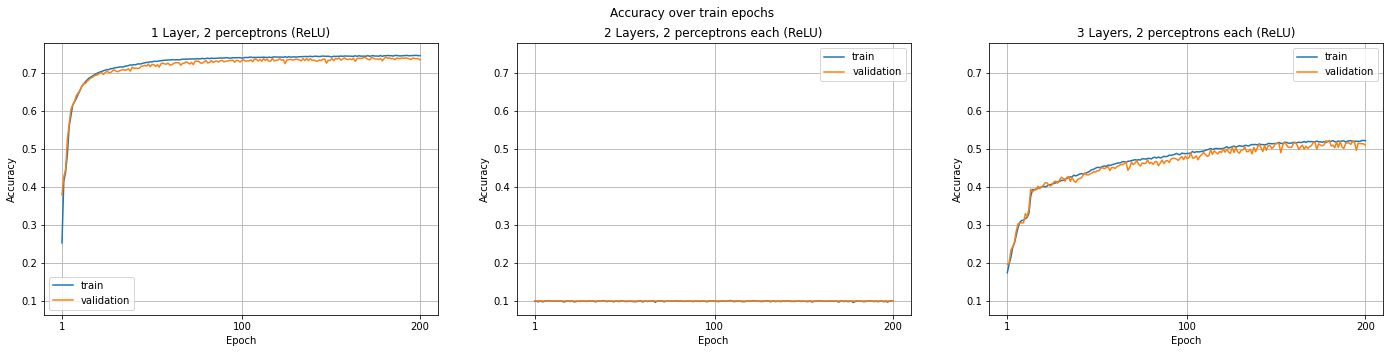

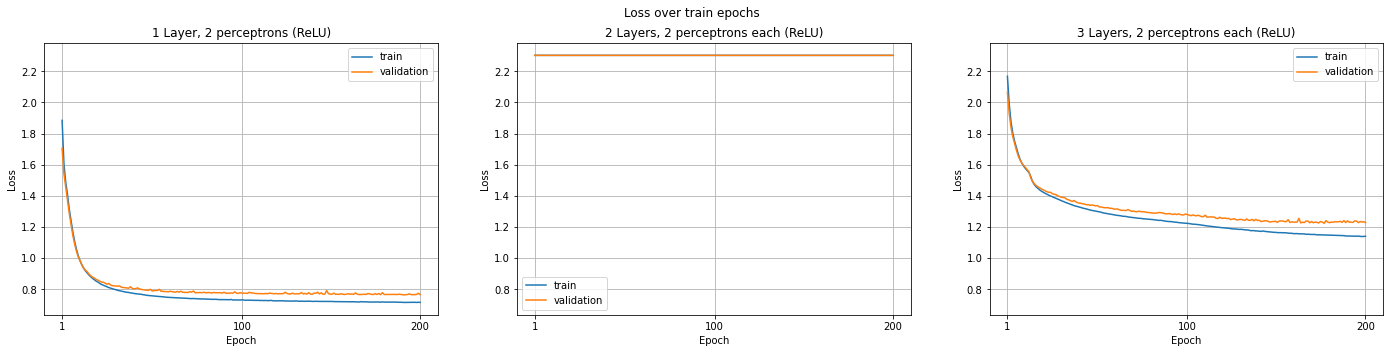

In [122]:
plot_model(model_1=mlp_1l_2_relu_b256, model_2=mlp_2l_2_relu_b256, model_3=mlp_3l_2_relu_b256, epochs=200,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 2 perceptrons (ReLU)', subtitle_2='2 Layers, 2 perceptrons each (ReLU)', subtitle_3='3 Layers, 2 perceptrons each (ReLU)')
plot_model(model_1=mlp_1l_2_relu_b256, model_2=mlp_2l_2_relu_b256, model_3=mlp_3l_2_relu_b256, epochs=200, loss=True,
    title='Loss over train epochs', subtitle_1='1 Layer, 2 perceptrons (ReLU)', subtitle_2='2 Layers, 2 perceptrons each (ReLU)', subtitle_3='3 Layers, 2 perceptrons each (ReLU)')

Luego de entrenar los modelos repetidas veces pudimos observar que en buena parte de los casos el Accuracy tiene una asíntota entre el 0.50 y 0.52, mientras que en otros casos esta métrica queda estancada en 0.48.
Estos modelos iniciales utilizan la tangente hiperbólica como función de activación.

Si bien inicialmente optamos por ReLU, algunas veces los casos quedaban estancados durante todo su entrenamiento con el Accuracy en 0.1 y el Loss en 2.3. Una de las hipótesis sobre la causa de esto es 'Dying ReLU problem'

Pruebas con tangente hiperbólica

In [108]:
mlp_1l_2_tanh = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='tanh'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_1l_2_tanh.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_1l_2_tanh.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_41 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 flatten_41 (Flatten)        (None, 784)               0         
                                                                 
 dense_124 (Dense)           (None, 2)                 1570      
                                                                 
 dense_125 (Dense)           (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [109]:
mlp_2l_2_tanh = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='tanh'),
    Dense(2, activation='tanh'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_2_tanh.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_2_tanh.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_42 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 flatten_42 (Flatten)        (None, 784)               0         
                                                                 
 dense_126 (Dense)           (None, 2)                 1570      
                                                                 
 dense_127 (Dense)           (None, 2)                 6         
                                                                 
 dense_128 (Dense)           (None, 10)                30        
                                                                 
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________________


In [110]:
mlp_3l_2_tanh = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='tanh'),
    Dense(2, activation='tanh'),
    Dense(2, activation='tanh'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_2_tanh.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_2_tanh.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_43 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 flatten_43 (Flatten)        (None, 784)               0         
                                                                 
 dense_129 (Dense)           (None, 2)                 1570      
                                                                 
 dense_130 (Dense)           (None, 2)                 6         
                                                                 
 dense_131 (Dense)           (None, 2)                 6         
                                                                 
 dense_132 (Dense)           (None, 10)                30        
                                                                 
Total params: 1,612
Trainable params: 1,612
Non-train

In [111]:
print('mlp_1l_2_tanh')
mlp_1l_2_tanh_b256 = fit_model(mlp_1l_2_tanh, batch_size=256, epochs=10, compare=True)
print('mlp_2l_2_tanh')
mlp_2l_2_tanh_b256 = fit_model(mlp_2l_2_tanh, batch_size=256, epochs=10, compare=True)
print('mlp_3l_2_tanh')
mlp_3l_2_tanh_b256 = fit_model(mlp_3l_2_tanh, batch_size=256, epochs=10, compare=True)

mlp_1l_2_tanh
Trained the model for 10 epochs
- Train: 	 Initial Accuracy: 0.2712 	 Final Accuracy: 0.4736 	 Initial Loss: 1.8982 	 Final Loss: 1.2335
- Validation: 	 Initial Accuracy: 0.3259 	 Final Accuracy: 0.4783 	 Initial Loss: 1.7501 	 Final Loss: 1.2319
mlp_2l_2_tanh
Trained the model for 10 epochs
- Train: 	 Initial Accuracy: 0.2816 	 Final Accuracy: 0.4212 	 Initial Loss: 2.0449 	 Final Loss: 1.1997
- Validation: 	 Initial Accuracy: 0.3426 	 Final Accuracy: 0.4153 	 Initial Loss: 1.8920 	 Final Loss: 1.2134
mlp_3l_2_tanh
Trained the model for 10 epochs
- Train: 	 Initial Accuracy: 0.2138 	 Final Accuracy: 0.4004 	 Initial Loss: 2.0498 	 Final Loss: 1.3743
- Validation: 	 Initial Accuracy: 0.2453 	 Final Accuracy: 0.3996 	 Initial Loss: 1.9223 	 Final Loss: 1.3839


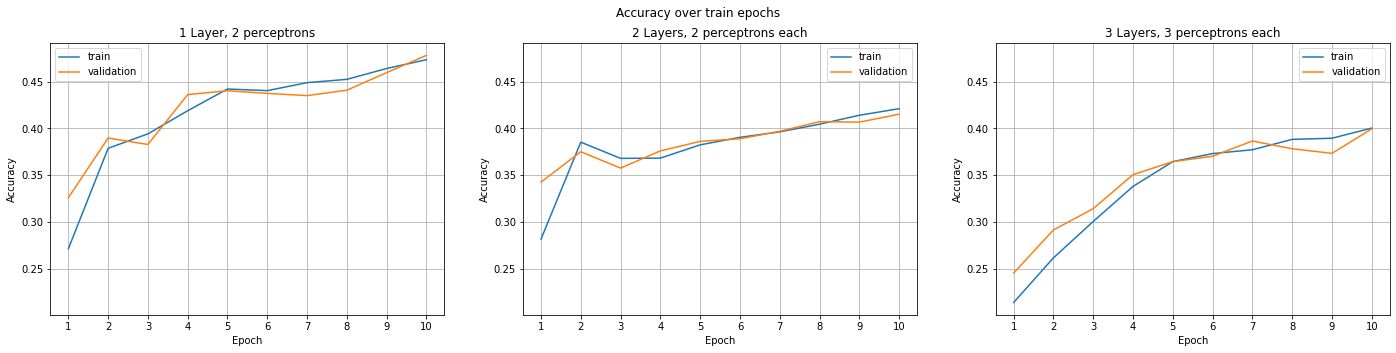

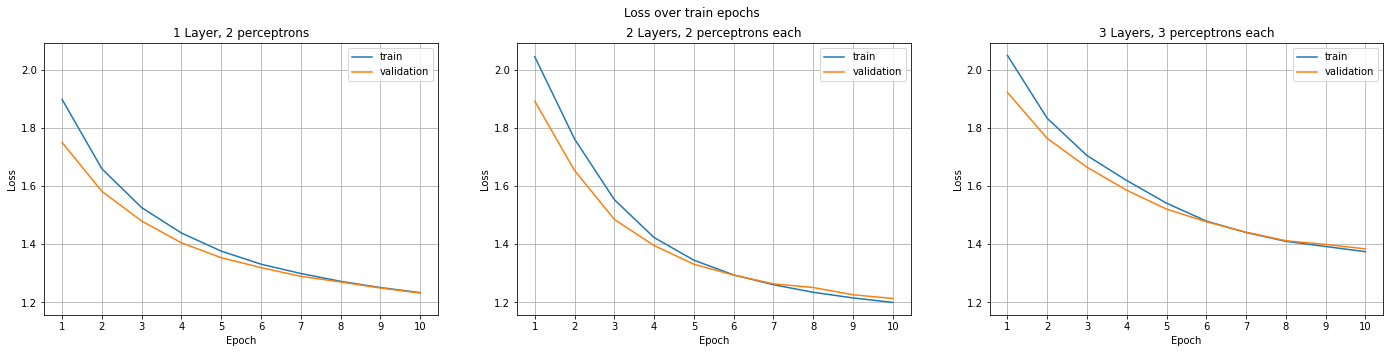

In [112]:
plot_model(model_1=mlp_1l_2_tanh_b256, model_2=mlp_2l_2_tanh_b256, model_3=mlp_3l_2_tanh_b256, epochs=10,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 2 perceptrons', subtitle_2='2 Layers, 2 perceptrons each', subtitle_3='3 Layers, 3 perceptrons each')
plot_model(model_1=mlp_1l_2_tanh_b256, model_2=mlp_2l_2_tanh_b256, model_3=mlp_3l_2_tanh_b256, epochs=10, loss=True,
    title='Loss over train epochs', subtitle_1='1 Layer, 2 perceptrons', subtitle_2='2 Layers, 2 perceptrons each', subtitle_3='3 Layers, 3 perceptrons each')

Luego de entrenar los modelos repetidas veces pudimos observar que en buena parte de los casos el Accuracy tiene una asíntota entre el 0.50 y 0.52, mientras que en otros casos esta métrica queda estancada en 0.48.
Estos modelos iniciales utilizan la tangente hiperbólica como función de activación.

Si bien inicialmente optamos por ReLU, algunas veces los casos quedaban estancados durante todo su entrenamiento con el Accuracy en 0.1 y el Loss en 2.3. Una de las hipótesis sobre la causa de esto es 'Dying ReLU problem'

In [ ]:
mlp_1l_2 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_1l_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_1l_2.summary()

In [ ]:
mlp_1l_2_b256 = fit_model(mlp_1l_2, batch_size=256, compare=True)

In [ ]:
mlp_2l_2 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_2.summary()

In [ ]:
mlp_2l_2_b256 = fit_model(mlp_2l_2, batch_size=256, compare=True)

In [ ]:
mlp_3l_2 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_2.summary()

In [ ]:
mlp_3l_2_b256 = fit_model(mlp_3l_2, batch_size=256, compare=True)

In [ ]:
plot_model(model_1=mlp_1l_2_b256, model_2=mlp_2l_2_b256, model_3=mlp_3l_2_b256,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 2 perceptrons', subtitle_2='2 Layers, 2 perceptrons each', subtitle_3='3 Layers, 2 perceptron each')
plot_model(model_1=mlp_1l_2_b256, model_2=mlp_2l_2_b256, model_3=mlp_3l_2_b256, loss=True,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 2 perceptrons', subtitle_2='2 Layers, 2 perceptrons each', subtitle_3='3 Layers, 2 perceptrons each')

## Epochs

In [ ]:
mlp_3l_100 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100.summary()

In [ ]:
mlp_3l_100_e10 = fit_model(mlp_3l_100, epochs=10)
mlp_3l_100_e20 = fit_model(mlp_3l_100, epochs=20)
mlp_3l_100_e30 = fit_model(mlp_3l_100, epochs=30)

In [ ]:
plot_model(model_1=mlp_3l_100_e10, model_2=mlp_3l_100_e20, model_3=mlp_3l_100_e30, epochs=30, 
    title='Accuracy over train epochs', subtitle_1='Epochs=10', subtitle_2='Epochs=20', subtitle_3='Epochs=30')

In [ ]:
plot_model(model_1=mlp_3l_100_e10, model_2=mlp_3l_100_e20, model_3=mlp_3l_100_e30, epochs=30, loss=True,
    title='Accuracy over train epochs', subtitle_1='Epochs=10', subtitle_2='Epochs=20', subtitle_3='Epochs=30')

## Batch Size

In [ ]:
mlp_3l_100 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100.summary()


In [ ]:
mlp_3l_100_b64 = fit_model(mlp_3l_100, batch_size=64)

In [ ]:
mlp_3l_100_b256 = fit_model(mlp_3l_100, batch_size=256)

In [ ]:
mlp_3l_100_b1024 = fit_model(mlp_3l_100, batch_size=1024)

In [ ]:
plot_model(model_1=mlp_3l_100_b64, model_2=mlp_3l_100_b256, model_3=mlp_3l_100_b1024,
    title='Accuracy over train epochs', subtitle_1='Batch Size=64', subtitle_2='Batch Size=256', subtitle_3='Batch Size=1024')

In [ ]:
plot_model(model_1=mlp_3l_100_b64, model_2=mlp_3l_100_b256, model_3=mlp_3l_100_b1024, loss=True, 
    title='Loss over train epochs', subtitle_1='Batch Size=64', subtitle_2='Batch Size=256', subtitle_3='Batch Size=1024')

El uso de un `batch_size` más alto tiene los siguientes efectos:

| batch_size | Tiempo (s)  |
| ---------- | ----------- |
| 64         | 58          |
| 256        | 26          |
| 1024       | 20          |

- El entrenamiento es, naturalmente, más rápido. 
- El accuracy de train aumenta a medida que aumenta el `batch_size` y hace overfitting.
- El loss de Validation continúa aumentando respecto al de Train a medida que pasan los `epochs`. Esto es otro indicativo de overfitting.

Estas observaciones nos indican que el modelo actual, con tres capas ocultas de 100 neuronas cada una, es tiene suficiente capacidad como para memorizar los datos de Train. En este caso tenemos varias alternativas:
1. Añadir capas de dropout.
2. Reducir la cantidad de capas y/o neuronas.
3. Añadir más datos.

Procedemos a testear la primer situación, utilizando capas de Dropout entre las capas ocultas de la red.

### Test con Dropout

In [ ]:
mlp_3l_100_d02 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_d02.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_d02.summary()

In [ ]:
mlp_3l_100_d02_b64 = fit_model(mlp_3l_100_d02, batch_size=64)

In [ ]:
mlp_3l_100_d02_b256 = fit_model(mlp_3l_100_d02, batch_size=256)

In [ ]:
mlp_3l_100_d02_b1024 = fit_model(mlp_3l_100_d02, batch_size=1024)

In [ ]:
plot_model(model_1=mlp_3l_100_d02_b64, model_2=mlp_3l_100_d02_b256, model_3=mlp_3l_100_d02_b1024, 
    title='Loss over train epochs', subtitle_1='Batch Size=64, Dropout=0.2', subtitle_2='Batch Size=256, Dropout=0.2', subtitle_3='Batch Size=1024, Dropout=0.2')

In [ ]:
plot_model(model_1=mlp_3l_100_d02_b64, model_2=mlp_3l_100_d02_b256, model_3=mlp_3l_100_d02_b1024, loss=True, 
    title='Loss over train epochs', subtitle_1='Batch Size=64, Dropout=0.2', subtitle_2='Batch Size=256, Dropout=0.2', subtitle_3='Batch Size=1024, Dropout=0.2')

La adición de tres capas de Dropout controló el crecimiento del loss de Validation y añadió ciertas irregularidades en las métricas, al menos comparándolo con los gráficos más 'suaves' obtenidos en el ejemplo anterior.
Esto es entendible debido a la naturaleza de cómo opera Dropout, al asignar valores 0 en los inputs de manera random con determinada frecuencia. Además, también subió levemente el piso del loss en Train.

| batch_size | Tiempo (s)  |
| ---------- | ----------- |
| 64         | 72          |
| 256        | 40          |
| 1024       | 33          |

### Test con menor cantidad de neuronas

In [ ]:
mlp_3l_10 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_10.summary()

In [ ]:
mlp_3l_10_b64 = fit_model(mlp_3l_10, batch_size=64)


In [ ]:
mlp_3l_10_b256 = fit_model(mlp_3l_10, batch_size=256)

In [ ]:
mlp_3l_10_b1024 = fit_model(mlp_3l_10, batch_size=1024)

In [ ]:
plot_model(model_1=mlp_3l_10_b64, model_2=mlp_3l_10_b256, model_3=mlp_3l_10_b1024,
    title='Accuracy over train epochs', subtitle_1='Batch Size=64', subtitle_2='Batch Size=256', subtitle_3='Batch Size=1024')

In [ ]:
plot_model(model_1=mlp_3l_10_b64, model_2=mlp_3l_10_b256, model_3=mlp_3l_10_b1024, loss=True, 
    title='Loss over train epochs', subtitle_1='Batch Size=64', subtitle_2='Batch Size=256', subtitle_3='Batch Size=1024')

Al reducir la cantidad de neuronas en un 90% (de 100 a 10) pero manteniendo las tres capas densas iniciales alcanzamos valores muy similares independientemente del `batch_size`. De todas maneras, en el 2do y 3er ejemplo el loss de Validation sigue incrementándose mientras el de Train se mantiene estable, lo cual indica un overfitting.

A partir de este momento tomamos como base al segundo modelo (con `batch_size = 256`) para continuar con la experimentación.

El hecho de que el loss no cambie a lo largo de los `epochs` es llamativo. Esto ocurrió cuando redujimos la cantidad de neuronas, por lo que podríamos suponer que la red ya no tiene capacidad de aprender. 
Procedemos a realizar dos cambios:
1. Disminuir el 

In [ ]:
mlp_3l_10_lr00001 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_10_lr00001.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001, #Default 0.001
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_10_lr00001.summary()

In [ ]:
mlp_3l_10_lr00001_b256 = fit_model(mlp_3l_10_lr00001, batch_size=256)

In [ ]:
mlp_4l_10 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_4l_10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_4l_10.summary()

In [ ]:
mlp_4l_10_b256 = fit_model(mlp_4l_10, batch_size=256)

In [ ]:
plot_model(model_1=mlp_3l_10_lr00001_b256, model_2=mlp_3l_10_b256, model_3=mlp_4l_10_b256,
    title='Loss over train epochs', subtitle_1='Batch Size=256, Learning Rate=0.0001')

In [ ]:
plot_model(model_1=mlp_3l_10_lr00001_b256, model_2=mlp_3l_10_b256, model_3=mlp_4l_10_b256, loss=True, 
    title='Loss over train epochs', subtitle_1='Batch Size=256')

## Learning Rate

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [ ]:
mlp_3l_100_lr0001 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_lr0001.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001, #Default
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_lr0001.summary()

In [ ]:
mlp_3l_100_lr0001_fit = fit_model(mlp_3l_100_lr0001)

In [ ]:
mlp_3l_100_lr001 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_lr001.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_lr001.summary()

In [ ]:
mlp_3l_100_lr001_fit = fit_model(mlp_3l_100_lr001)

In [ ]:
mlp_3l_100_lr01 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_lr01.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.1,
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_lr01.summary()

In [ ]:
mlp_3l_100_lr01_fit = fit_model(mlp_3l_100_lr01)

In [ ]:
plot_model(model_1=mlp_3l_100_lr0001_fit, model_2=mlp_3l_100_lr001_fit, model_3=mlp_3l_100_lr01_fit, 
    title='Accuracy over train epochs with different learning rates', subtitle_1='Learning Rate=0.001', subtitle_2='Learning Rate=0.01', subtitle_3='Learning Rate=0.1')

In [ ]:
plot_model(model_1=mlp_3l_100_lr0001_fit, model_2=mlp_3l_100_lr001_fit, model_3=mlp_3l_100_lr01_fit, loss=True,
    title='Accuracy over train epochs with different learning rates', subtitle_1='Learning Rate=0.001', subtitle_2='Learning Rate=0.01', subtitle_3='Learning Rate=0.1')

Puede apreciarse que al utilizar un learning rate 10 veces más grande al default (0.01, en lugar de 0.001)

## Amount of neurons

In [ ]:
mlp_3l_10 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_10.summary()

In [ ]:
mlp_3l_20 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_20.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_20.summary()

In [ ]:
mlp_3l_40 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(40, activation='relu'),
    Dense(40, activation='relu'),
    Dense(40, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_40.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_40.summary()

In [ ]:
mlp_3l_10_fit = fit_model(mlp_3l_10)
mlp_3l_20_fit = fit_model(mlp_3l_20)
mlp_3l_40_fit = fit_model(mlp_3l_40)

In [ ]:
plot_model(model_1=mlp_3l_10_fit, epochs=30)

In [ ]:
plot_model(model_1=mlp_3l_10_fit, model_2=mlp_3l_20_fit, model_3=mlp_3l_40_fit,
    title="MLP TEST NO. 1", subtitle_1='MOD1', subtitle_2='MOD2', subtitle_3='MOD3')

# Grid Search MLP

param_grid = {
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [x for x in itertools.product((10,50,100),repeat=3)],
    'activation': ["logistic", "relu", "tanh"]
}  
base_estimator = MLP

In [ ]:
# Reshape de X_train a 2D para GridSearchCV
feature_vector_length = 784
num_classes = 10

X_trainR = X_train.reshape(X_train.shape[0], feature_vector_length)
X_testR = X_test.reshape(X_test.shape[0], feature_vector_length)

import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

# defining parameter range 
param_grid = {
    'hidden_layer_sizes': [(10,10),(10,10,10)],
    'batch_size': [128, 256, 512],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': 10.0 ** -np.arange(1, 5),
    
    'max_iter': [30],
    'solver': ['adam'],
}  

'''
grid2 = GridSearchCV(MLPClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, cv=3)

# fitting the model for grid search 
grid2.fit(X_trainR, Y_train) 
 
# print best parameter after tuning 
print(grid2.best_params_) 
grid_predictions = grid2.predict(X_testR) 
   
# print classification report 
print(classification_report(Y_test, grid_predictions)) 
'''

In [ ]:
model = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    
    Convolution2D(input_shape=(28, 28, 1), filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x1, y salida de 26x26x8
    Dropout(0.2),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 58x58x8
    Dropout(0.2),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 14x14x8
    
    Flatten(),
    # salida de 1568
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(LABELS), activation='softmax'),
    # salida de 10
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

model.summary()

In [ ]:
history = model.fit(
    X_train,
    Y_train, 
    epochs=5,
    batch_size=500,
    validation_data=(X_test, Y_test),
)

# Prunning

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras